# Implementation with time measurements

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time

from fairdivision.algorithms.envy_cycle_elimination import create_envy_graph, get_unenvied_agent, eliminate_cycle, update_graph
from fairdivision.experiments.measurements import *
from fairdivision.utils.allocation import Allocation
from fairdivision.utils.generators import *

LABELS = [
    "envy cycle elimination",
    "create graph", 
    "get unenvied agent", 
    "cycles elimination", 
    "get item to allocate", 
    "allocate item", 
    "remove item", 
    "update graph"
]

def initialize_durations():
    return {label: [] for label in LABELS}

In [2]:
def envy_cycle_elimination_favorite(agents, items, allocation=None):
    durations = initialize_durations()
    start_time = time.time()

    items_left = items.copy()

    if allocation is None:
        allocation = Allocation(agents)

    graph, create_graph_time = with_duration(create_envy_graph, agents, allocation)

    durations["create graph"] = [create_graph_time]

    while items_left.size() > 0:
        unenvied_agent, get_unenvied_time = with_duration(get_unenvied_agent, graph, agents, allocation)
        durations["get unenvied agent"].append(get_unenvied_time)

        cycle_start_time = time.time()
        while unenvied_agent is None:
            cycle = nx.find_cycle(graph)
            graph = eliminate_cycle(agents, cycle, allocation)

            unenvied_agent = get_unenvied_agent(graph, agents, allocation)

        durations["cycles elimination"].append(time.time() - cycle_start_time)

        # getting the favorite item to allocate
        item_to_allocate, item_to_allocate_time = with_duration(unenvied_agent.get_favorite_item, items_left)
        durations["get item to allocate"].append(item_to_allocate_time)

        _, allocate_time = with_duration(allocation.allocate, unenvied_agent, item_to_allocate)
        durations["allocate item"].append(allocate_time)

        _, remove_time = with_duration(items_left.remove_item, item_to_allocate)
        durations["remove item"].append(remove_time)

        _, update_time = with_duration(update_graph, graph, agents, allocation, unenvied_agent)
        durations["update graph"].append(update_time)

    durations["envy cycle elimination"] = [time.time() - start_time]

    return allocation, durations

In [3]:
def envy_cycle_elimination_any(agents, items, allocation=None):
    durations = initialize_durations()
    start_time = time.time()

    items_left = items.copy()

    if allocation is None:
        allocation = Allocation(agents)

    graph, create_graph_time = with_duration(create_envy_graph, agents, allocation)

    durations["create graph"] = [create_graph_time]

    while items_left.size() > 0:
        unenvied_agent, get_unenvied_time = with_duration(get_unenvied_agent, graph, agents, allocation)
        durations["get unenvied agent"].append(get_unenvied_time)

        cycle_start_time = time.time()
        while unenvied_agent is None:
            cycle = nx.find_cycle(graph)
            graph = eliminate_cycle(agents, cycle, allocation)

            unenvied_agent = get_unenvied_agent(graph, agents, allocation)

        durations["cycles elimination"].append(time.time() - cycle_start_time)

        # getting any item to allocate
        start_item_to_allocate = time.time()
        item_to_allocate = items_left.get_items()[0]        
        durations["get item to allocate"].append(time.time() - start_item_to_allocate)

        _, allocate_time = with_duration(allocation.allocate, unenvied_agent, item_to_allocate)
        durations["allocate item"].append(allocate_time)

        _, remove_time = with_duration(items_left.remove_item, item_to_allocate)
        durations["remove item"].append(remove_time)

        _, update_time = with_duration(update_graph, graph, agents, allocation, unenvied_agent)
        durations["update graph"].append(update_time)

    durations["envy cycle elimination"] = [time.time() - start_time]

    return allocation, durations

In [4]:
from fairdivision.algorithms.fast_envy_cycle_elimination import Node, FavoriteItems, get_favorite_items

def fast_envy_cycle_elimination(agents, items, allocation=None):
    durations = initialize_durations()
    start_time = time.time()

    items_left = items.copy()

    favorite_items = get_favorite_items(agents, items)

    if allocation is None:
        allocation = Allocation(agents)

    graph, create_graph_time = with_duration(create_envy_graph, agents, allocation)

    durations["create graph"] = [create_graph_time]

    while items_left.size() > 0:
        unenvied_agent, get_unenvied_time = with_duration(get_unenvied_agent, graph, agents, allocation)
        durations["get unenvied agent"].append(get_unenvied_time)

        cycle_start_time = time.time()
        while unenvied_agent is None:
            cycle = nx.find_cycle(graph)
            graph = eliminate_cycle(agents, cycle, allocation)

            unenvied_agent = get_unenvied_agent(graph, agents, allocation)

        durations["cycles elimination"].append(time.time() - cycle_start_time)

        # getting favorite item to allocate in fast way
        start_item_to_allocate = time.time()
        
        item_to_allocate = favorite_items[unenvied_agent].get_favorite_item()
        for agent in agents:
            favorite_items[agent].remove_item(item_to_allocate)

        durations["get item to allocate"].append(time.time() - start_item_to_allocate)
        
        _, allocate_time = with_duration(allocation.allocate, unenvied_agent, item_to_allocate)
        durations["allocate item"].append(allocate_time)

        _, remove_time = with_duration(items_left.remove_item, item_to_allocate)
        durations["remove item"].append(remove_time)

        _, update_time = with_duration(update_graph, graph, agents, allocation, unenvied_agent)
        durations["update graph"].append(update_time)

    durations["envy cycle elimination"] = [time.time() - start_time]

    return allocation, durations

In [5]:
def run_ece(n, m, generator, iterations, algorithm):
    seed = random.randint(1, 100_000_000)
    random.seed(seed)
    
    measurements = []
    
    for _ in range(iterations):
        agents = generate_agents(n)
        items = generate_items(m)
        
        generate_valuations(agents, items, generator)
        
        _, durations = algorithm(agents, items)
        
        measurements.append(durations)

    return measurements

# Experiments

## n = 10, general instances

10 20 30 40 50 60 70 80 90 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

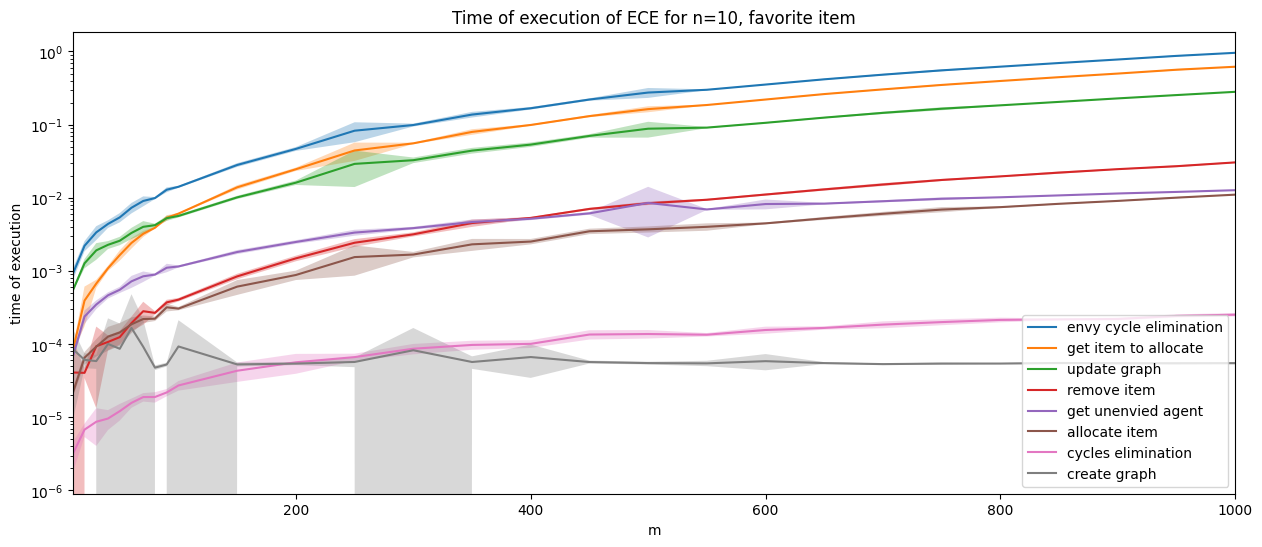

In [13]:
n = 10
ms = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1050, 50)))

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for m in ms:
    print(m, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_favorite)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ms, means, stds, "m", "time of execution", "Time of execution of ECE for n=10, favorite item")

10 20 30 40 50 60 70 80 90 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

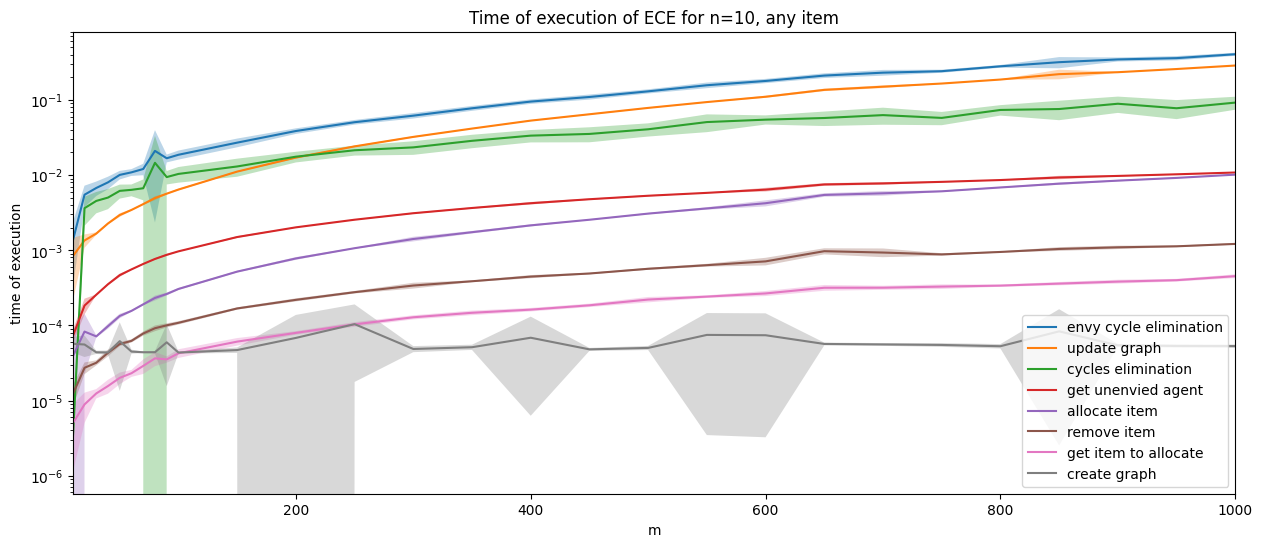

In [14]:
n = 10
ms = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1050, 50)))

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for m in ms:
    print(m, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_any)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ms, means, stds, "m", "time of execution", "Time of execution of ECE for n=10, any item")

10 20 30 40 50 60 70 80 90 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

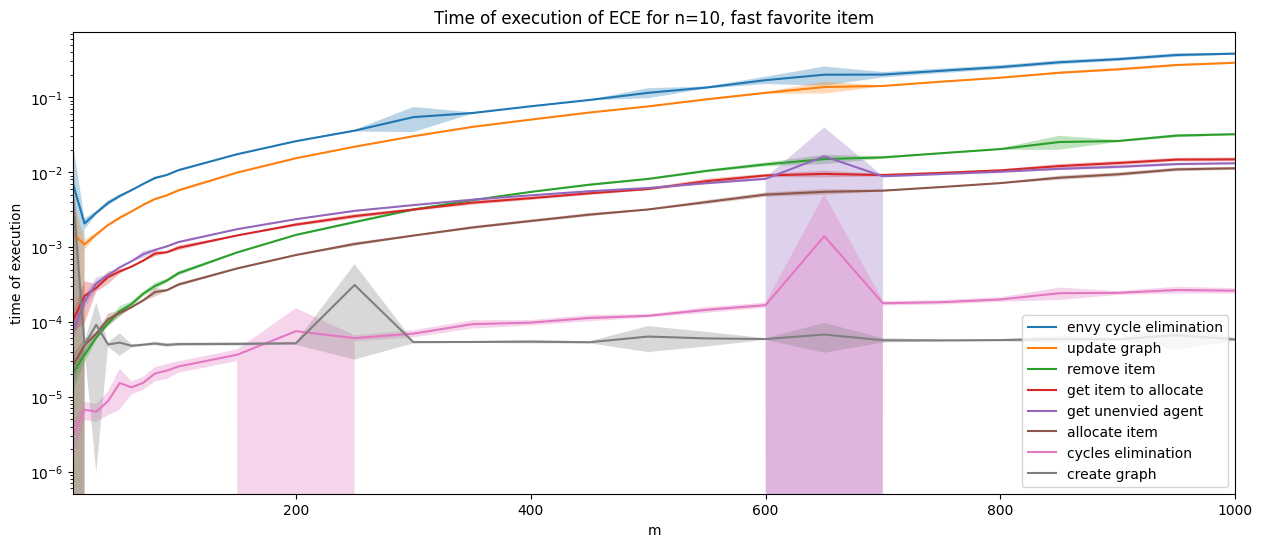

In [15]:
n = 10
ms = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1050, 50)))

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for m in ms:
    print(m, end=" ")
    measurements = run_ece(n, m, generator, iterations, fast_envy_cycle_elimination)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ms, means, stds, "m", "time of execution", "Time of execution of ECE for n=10, fast favorite item")

## n = 10, ordered instances

10 20 30 40 50 60 70 80 90 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

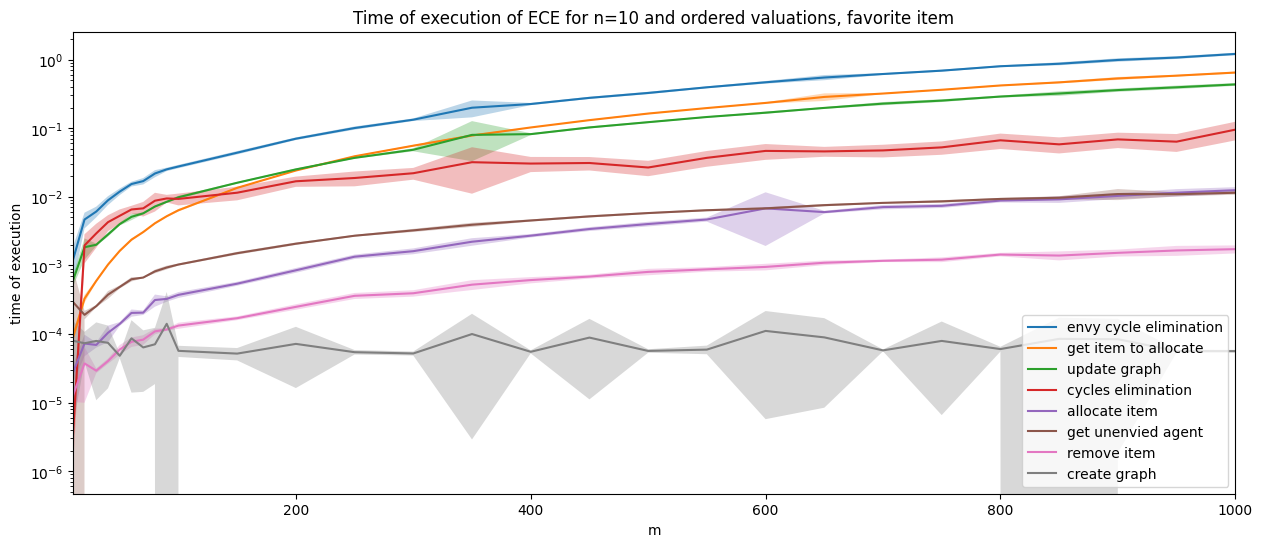

In [16]:
n = 10
ms = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1050, 50)))

generator = OrderedGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for m in ms:
    print(m, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_favorite)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ms, means, stds, "m", "time of execution", "Time of execution of ECE for n=10 and ordered valuations, favorite item")

10 20 30 40 50 60 70 80 90 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

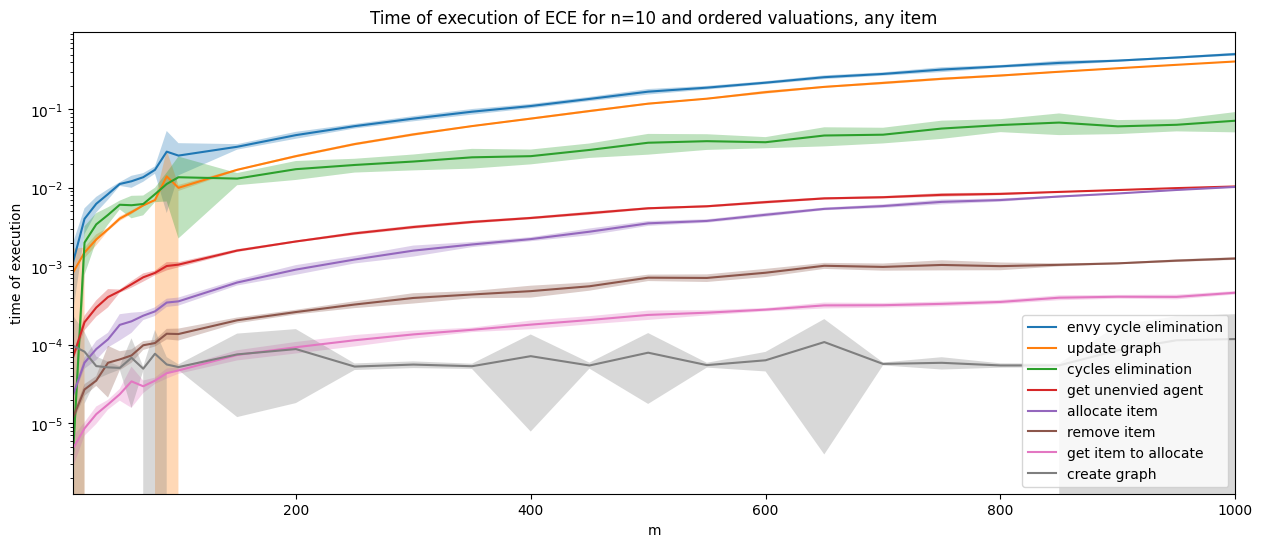

In [17]:
n = 10
ms = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1050, 50)))

generator = OrderedGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for m in ms:
    print(m, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_any)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ms, means, stds, "m", "time of execution", "Time of execution of ECE for n=10 and ordered valuations, any item")

10 20 30 40 50 60 70 80 90 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 

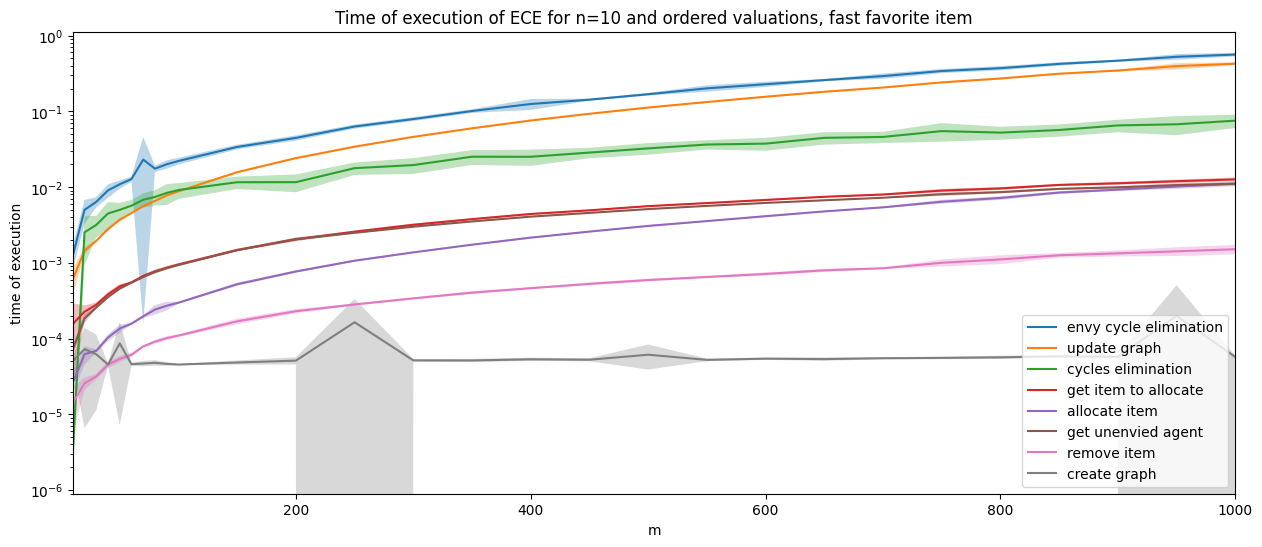

In [18]:
n = 10
ms = np.concatenate((np.arange(10, 100, 10), np.arange(100, 1050, 50)))

generator = OrderedGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for m in ms:
    print(m, end=" ")
    measurements = run_ece(n, m, generator, iterations, fast_envy_cycle_elimination)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ms, means, stds, "m", "time of execution", "Time of execution of ECE for n=10 and ordered valuations, fast favorite item")

## m = 100, general instances

2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 100 200 300 400 500 600 700 800 900 1000 

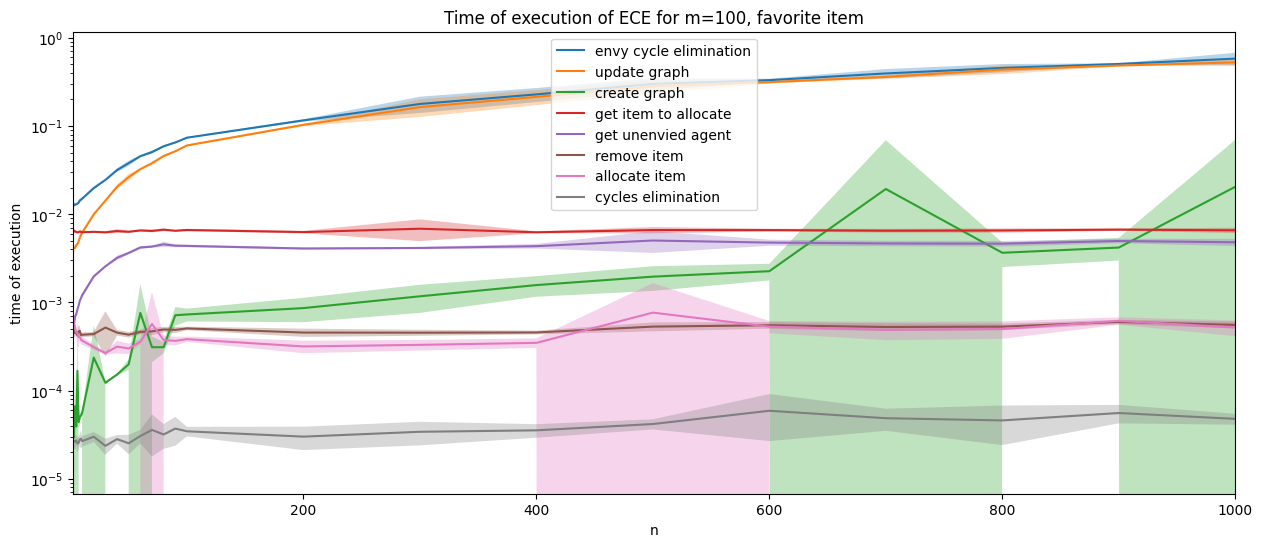

In [19]:
ns = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 1100, 100)))
m = 100

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for n in ns:
    print(n, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_favorite)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ns, means, stds, "n", "time of execution", "Time of execution of ECE for m=100, favorite item")

2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 100 200 300 400 500 600 700 800 900 1000 

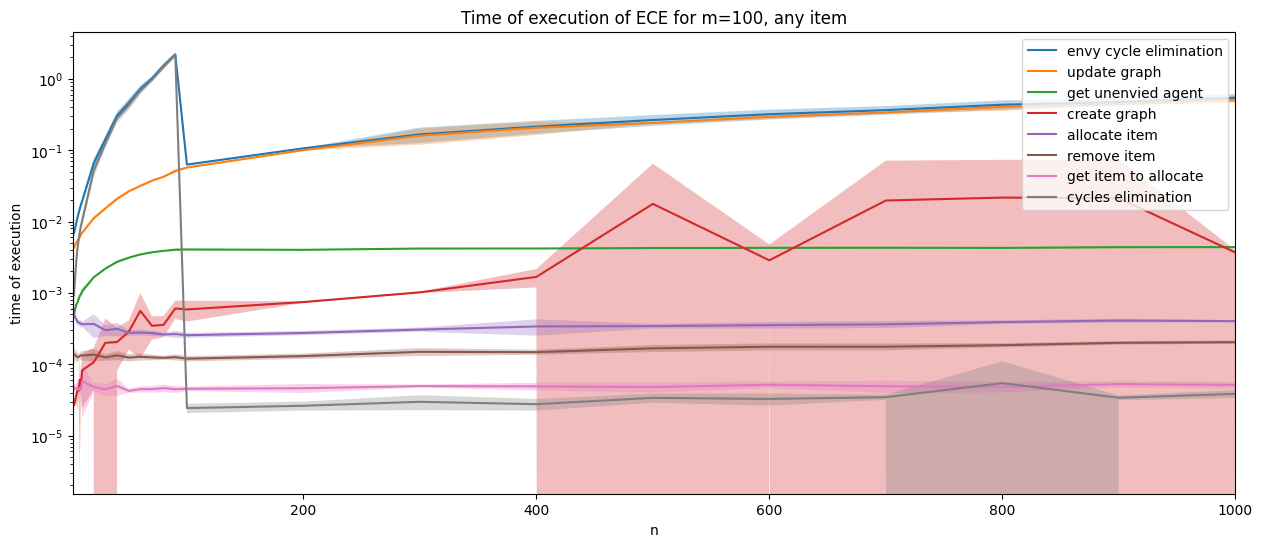

In [20]:
ns = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 1100, 100)))
m = 100

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for n in ns:
    print(n, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_any)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ns, means, stds, "n", "time of execution", "Time of execution of ECE for m=100, any item")

2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 100 200 300 400 500 600 700 800 900 1000 

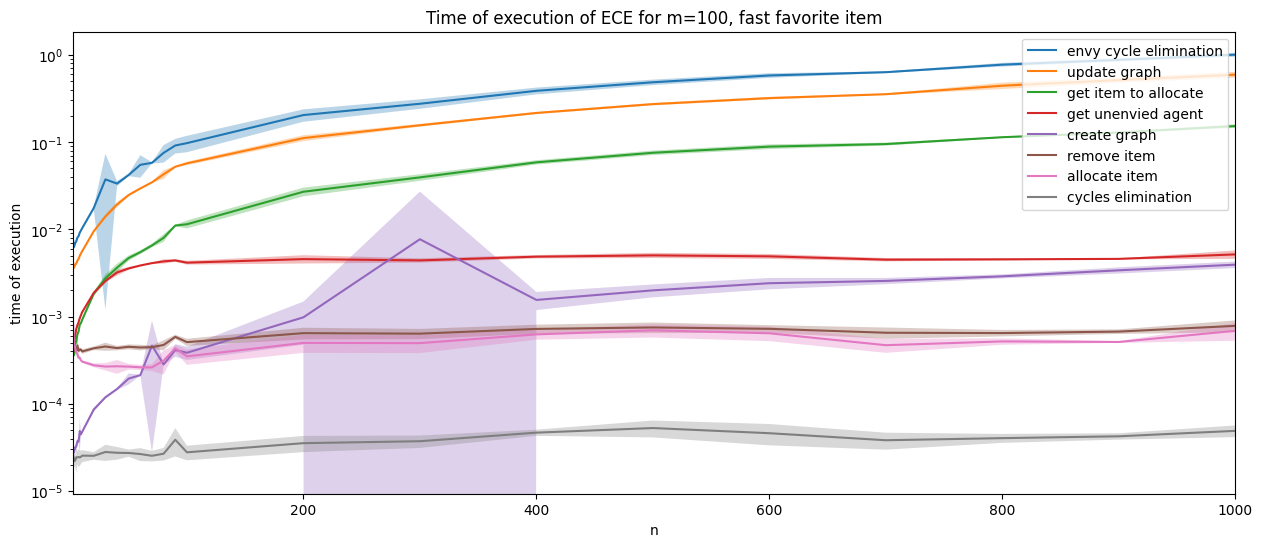

In [21]:
ns = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 1100, 100)))
m = 100

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for n in ns:
    print(n, end=" ")
    measurements = run_ece(n, m, generator, iterations, fast_envy_cycle_elimination)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ns, means, stds, "n", "time of execution", "Time of execution of ECE for m=100, fast favorite item")

## m = 4n, general instances

2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 100 125 

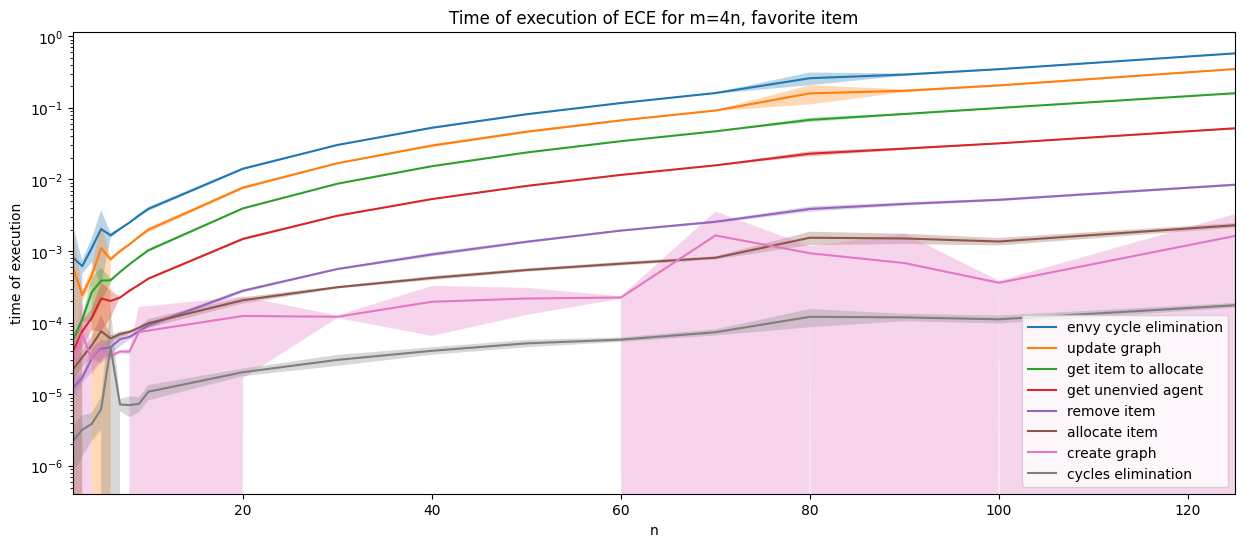

In [22]:
ns = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 150, 25)))
ms = 4 * ns

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for n, m in zip(ns, ms):
    print(n, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_favorite)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ns, means, stds, "n", "time of execution", "Time of execution of ECE for m=4n, favorite item")

2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 100 125 

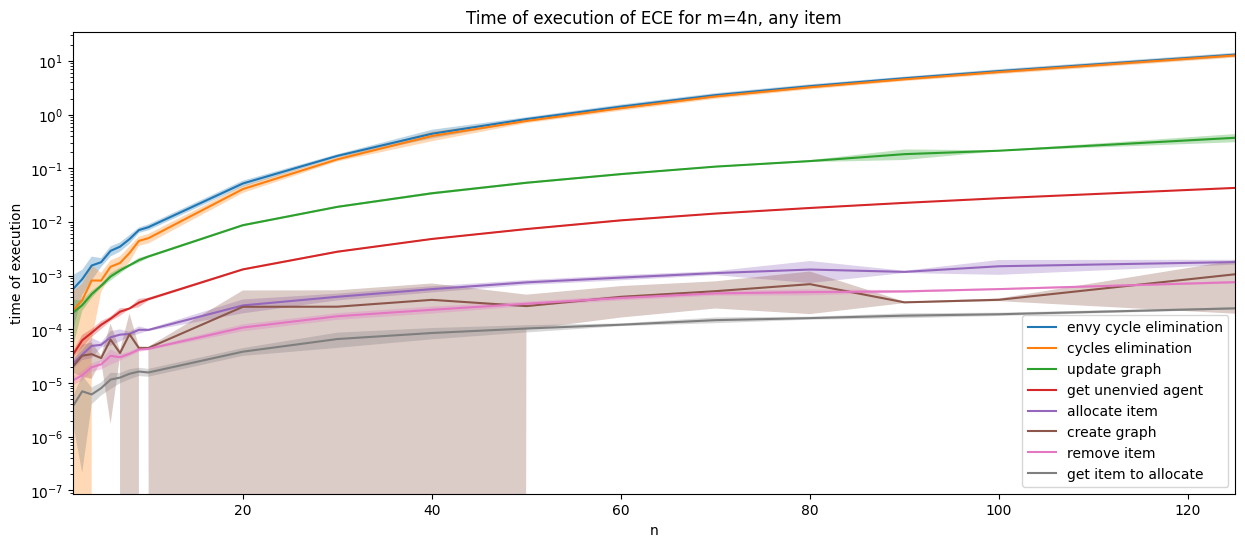

In [23]:
ns = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 150, 25)))
ms = 4 * ns

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for n, m in zip(ns, ms):
    print(n, end=" ")
    measurements = run_ece(n, m, generator, iterations, envy_cycle_elimination_any)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ns, means, stds, "n", "time of execution", "Time of execution of ECE for m=4n, any item")

2 3 4 5 6 7 8 9 10 20 30 40 50 60 70 80 90 100 125 

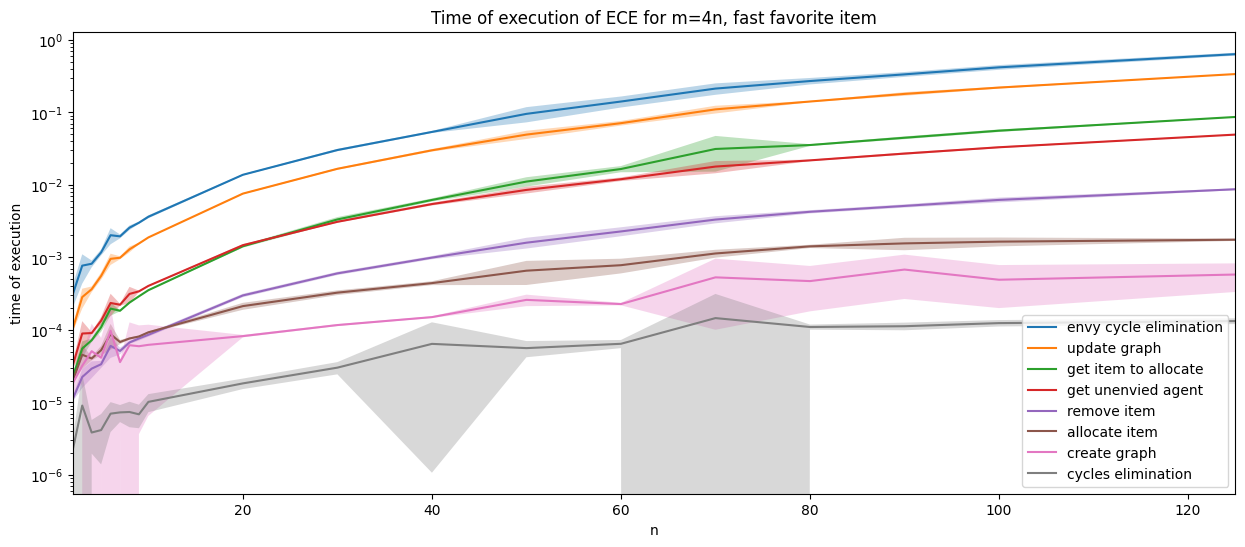

In [24]:
ns = np.concatenate((np.arange(2, 10, 1), np.arange(10, 100, 10), np.arange(100, 150, 25)))
ms = 4 * ns

generator = AdditiveGenerator(min=0, max=10000)

iterations = 10

means, stds = initialize_statistics(LABELS)

for n, m in zip(ns, ms):
    print(n, end=" ")
    measurements = run_ece(n, m, generator, iterations, fast_envy_cycle_elimination)
    means, stds = update_statistics(means, stds, measurements, LABELS)

draw_statistics(ns, means, stds, "n", "time of execution", "Time of execution of ECE for m=4n, fast favorite item")